### Проект e-commerce: 
##### Нас попросили проанализировать совершенные покупки и ответить на следующие вопросы:

##### 1. Сколько у нас пользователей, которые совершили покупку только один раз? 

##### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

##### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

##### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

##### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь необходтмо выявить когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

##### 6. Необходимо построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 


#### Файлы:

##### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
##### olist_orders_dataset.csv —  таблица заказов
##### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
##### Уникальные статусы заказов в таблице olist_orders_dataset: 
#### created —  создан 
#### approved —  подтверждён 
#### invoiced —  выставлен счёт 
#### processing —  в процессе сборки заказа 
#### shipped —  отгружен со склада 
#### delivered —  доставлен пользователю 
#### unavailable —  недоступен 
#### canceled —  отменён




##### Для начала проведем разведывательный анализ данных. Посмотрим на типы данных  и приведем их нужным по необходимости, проверим  размерность таблиц, есть ли пропущенные значения и дубликаты.

In [1]:
# загружаем нужные библиотеки
import pandas as pd
import numpy as np
from operator import attrgetter
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# считываем датасеты. Все данные с датами приводим к формату дат.
customers_df   = pd.read_csv('olist_customers_dataset.csv')
orders_df      = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp','order_approved_at',
                                                                           'order_delivered_carrier_date', 'order_delivered_customer_date',
                                                                           'order_estimated_delivery_date'])
order_items_df = pd.read_csv('olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date'])

In [3]:
customers_df.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [4]:
customers_df.shape

(99441, 5)

In [5]:
customers_df.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
customers_df.duplicated().sum()

0

In [7]:
orders_df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [8]:
orders_df.shape

(99441, 8)

In [9]:
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [10]:
orders_df.duplicated().sum()

0

In [11]:
order_items_df.shape

(112650, 7)

In [12]:
order_items_df.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [13]:
order_items_df.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [14]:
order_items_df.duplicated().sum()

0

In [15]:
# соединяем данные в один датасет
df = customers_df.merge(orders_df, on='customer_id')

#####  1. Сколько у нас пользователей, которые совершили покупку только один раз? 

In [16]:
df_1 = df

In [17]:
df_1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [18]:
df_1.order_status.unique()

array(['delivered', 'canceled', 'invoiced', 'shipped', 'processing',
       'unavailable', 'approved', 'created'], dtype=object)

Примем за покупку все order_status, кроме "canceled" и "unavailable"

In [19]:
df_1.query('order_status != "canceled" or order_status != "unavailable" ')\
    .groupby('customer_unique_id', as_index=False)\
    .agg({'order_id':'count'})\
    .query('order_id==1')\
    .customer_unique_id.nunique()

93099

### Ответ: 93099 пользователей, которые совершили покупку только один раз

##### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [20]:
# соединяем нужные данные в один датасет
all_orders = orders_df.merge(order_items_df, on = 'order_id', how='inner')

In [21]:
all_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [22]:
# отбираем те заказы, которые не были доставлены
undelivered_orders = orders_df.query('order_status == "canceled" or order_status == "unavailable"')

In [23]:
# добавила месяц заказа
undelivered_orders['month_order'] = undelivered_orders.order_purchase_timestamp.dt.to_period('M')

C:\Users\Tanya\AppData\Local\Temp/ipykernel_9508/3736188330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undelivered_orders['month_order'] = undelivered_orders.order_purchase_timestamp.dt.to_period('M')


In [24]:
# группироуем данные и считаем среднее количество недоставленных заказов
undelivered_orders.groupby(['order_status', 'month_order'])\
    .agg({'order_id':'count'})\
    .groupby('order_status')\
    .agg({'order_id':'mean'})\
    .reset_index()\
    .round()

,order_status,order_id
0,canceled,26.0
1,unavailable,29.0


### Ответ: по причине отмены в среднем не доставляется 26 заказов в месяц. По причине недоступности  в среднем не доставляется 29 заказов в месяц.

#### 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [25]:
# оставим только те статусы заказа, которые мы считаем покупкой
df_3 = all_orders.query('order_status != "canceled" or order_status != "unavailable"')

In [26]:
# переведем дату покупки в день недели
df_3['week_day'] = df_3['order_purchase_timestamp'].dt.day_name()

In [79]:
#агрегировала таблицу так, чтобы на выходе получили id товара и день недели, в который товар чаще всего покупают
df_result = df_3.groupby(['week_day','product_id'])\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'quantity'})\
    .sort_values('quantity',ascending=False)\
    .groupby('product_id')\
    .agg({'quantity': 'idxmax'})\
    
df_result

,quantity
product_id,
00066f42aeeb9f3007548bb9d3f33c38,"(Sunday, 00066f42aeeb9f3007548bb9d3f33c38)"
00088930e925c41fd95ebfe695fd2655,"(Tuesday, 00088930e925c41fd95ebfe695fd2655)"
0009406fd7479715e4bef61dd91f2462,"(Thursday, 0009406fd7479715e4bef61dd91f2462)"
000b8f95fcb9e0096488278317764d19,"(Friday, 000b8f95fcb9e0096488278317764d19)"
000d9be29b5207b54e86aa1b1ac54872,"(Tuesday, 000d9be29b5207b54e86aa1b1ac54872)"
...,...
fff6177642830a9a94a0f2cba5e476d1,"(Sunday, fff6177642830a9a94a0f2cba5e476d1)"
fff81cc3158d2725c0655ab9ba0f712c,"(Monday, fff81cc3158d2725c0655ab9ba0f712c)"
fff9553ac224cec9d15d49f5a263411f,"(Friday, fff9553ac224cec9d15d49f5a263411f)"


#### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

Прежде чем, считать среднее количество покупок, необходимо учесть, что внутри месяца может быть не целое количество недель.

In [81]:
# соединяем нужные данные в одну таблицу
customers_and_orders = customers_df.merge(orders_df, on='customer_id')

In [82]:
# отбираю то, что считаю покупкой
df_4 = customers_and_orders.query('order_status != "canceled" or order_status != "unavailable"')

In [83]:
# перевожу столбец с месяцем в форматы даты (пероид месяц)
df_4['order_month'] = df_4.order_purchase_timestamp.dt.to_period('M')

In [84]:
# считаю количество дней в месяце
df_4['days'] = df_4['order_month'].dt.daysinmonth

In [85]:
# создаю столбец с количеством недель в каждом месяце
df_4['weeks'] = df_4['days']/7

In [101]:
avg_df_4 = df_4.groupby(['customer_unique_id','order_month','weeks'], as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'quantity'})
avg_df_4

,customer_unique_id,order_month,weeks,quantity
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1
...,...,...,...,...
98041,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,4.285714,1
98042,fffea47cd6d3cc0a88bd621562a9d061,2017-12,4.428571,1
98043,ffff371b4d645b6ecea244b27531430a,2017-02,4.000000,1
98044,ffff5962728ec6157033ef9805bacc48,2018-05,4.428571,1


In [102]:
# создаю новый столбец, в котором будет среднее количество покупок по месяцам
avg_df_4['avg_purсhase'] = avg_df_4.quantity / avg_df_4.weeks

In [103]:
avg_df_4

,customer_unique_id,order_month,weeks,quantity,avg_purсhase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,4.428571,1,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.285714,1,0.233333
...,...,...,...,...,...
98041,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,4.285714,1,0.233333
98042,fffea47cd6d3cc0a88bd621562a9d061,2017-12,4.428571,1,0.225806
98043,ffff371b4d645b6ecea244b27531430a,2017-02,4.000000,1,0.250000
98044,ffff5962728ec6157033ef9805bacc48,2018-05,4.428571,1,0.225806


##### 5. Далее приступаем к когортному анализу:

In [105]:
#убираем то, что не считается покупкой
df = df.query('order_status!="unavailable" or order_status!= "invoiced"')

#### Далее создаем столбцы cohort и order_month. Первый указывает месячную когорту на основе даты первой покупки (рассчитывается на одного клиента). Последний - это усеченный месяц даты покупки.

In [106]:
df['cohort'] = df.groupby('customer_unique_id')['order_purchase_timestamp']\
    .transform('min') \
    .dt.to_period('M') 

In [107]:
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')

In [108]:
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cohort,order_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,2018-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,2018-04,2018-04
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,2018-04,2018-04
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,2018-04,2018-04
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,2017-11,2017-11


#### Агрегируем данные по cohort и order_month и подсчитываем количество уникальных клиентов в каждой группе. Дополнительно добавляем period_number, указывающий количество периодов между месяцем когорты и месяцем покупки.

In [109]:
df_cohort = df.groupby(['cohort','order_month'])\
    .agg(n_customers=('customer_unique_id', 'nunique')) \
              .reset_index(drop=False)

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [110]:
df_cohort

,cohort,order_month,n_customers,period_number
0,2016-09,2016-09,4,0
1,2016-10,2016-10,321,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11
...,...,...,...,...
220,2018-08,2018-08,6271,0
221,2018-08,2018-09,7,1
222,2018-08,2018-10,2,2
223,2018-09,2018-09,5,0


##### поворачиваем таблицу df_cohort таким образом, чтобы каждая строка содержала  информацию о данной когорте, а каждый столбец содержал значения за определенный период.

In [111]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [112]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2636.0,13.0,10.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2352.0,14.0,5.0,4.0,8.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,5.0,NaN,NaN,NaN
2017-05,3596.0,18.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,9.0,12.0,9.0,1.0,7.0,9.0,NaN,NaN,NaN,NaN
2017-06,3139.0,15.0,11.0,13.0,8.0,12.0,12.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


##### Чтобы получить матрицу удержания , нам нужно разделить значения каждой строки на первое значение строки, которое на самом деле является размером когорты — все клиенты, которые сделали свою первую покупку в данном месяце.

In [113]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

In [114]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003115,NaN,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,NaN,0.003115,0.006231,0.006231
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003927,0.002618,0.001309,0.003927,0.001309,0.005236,0.001309,0.001309,NaN,0.003927,0.001309,0.007853,0.003927,0.001309,0.001309,0.002618,0.003927,0.001309,NaN
2017-02,1.0,0.002283,0.002854,0.001142,0.003995,0.001142,0.002283,0.001712,0.001712,0.002283,0.001142,0.002854,0.001712,0.001712,0.001142,0.000571,0.000571,0.002283,NaN,NaN
2017-03,1.0,0.004932,0.003794,0.003794,0.003414,0.001517,0.001517,0.003035,0.003414,0.000759,0.003794,0.001517,0.002276,0.001138,0.001517,0.002276,0.000759,0.001517,NaN,NaN
2017-04,1.0,0.005952,0.002126,0.001701,0.003401,0.002551,0.003401,0.002976,0.002976,0.001701,0.002551,0.000850,0.000850,0.000425,0.000850,0.000850,0.002126,NaN,NaN,NaN
2017-05,1.0,0.005006,0.005006,0.003893,0.003059,0.003337,0.004171,0.001669,0.002503,0.003059,0.002503,0.003337,0.002503,0.000278,0.001947,0.002503,NaN,NaN,NaN,NaN
2017-06,1.0,0.004779,0.003504,0.004141,0.002549,0.003823,0.003823,0.002230,0.001274,0.002230,0.003186,0.003504,0.001593,0.001274,0.001911,NaN,NaN,NaN,NaN,NaN


#### Создадим тепловую карту, чтобы наглядно увидеть когорты с самым высоким retention за 3й месяц:

<AxesSubplot:xlabel='period_number', ylabel='cohort'>

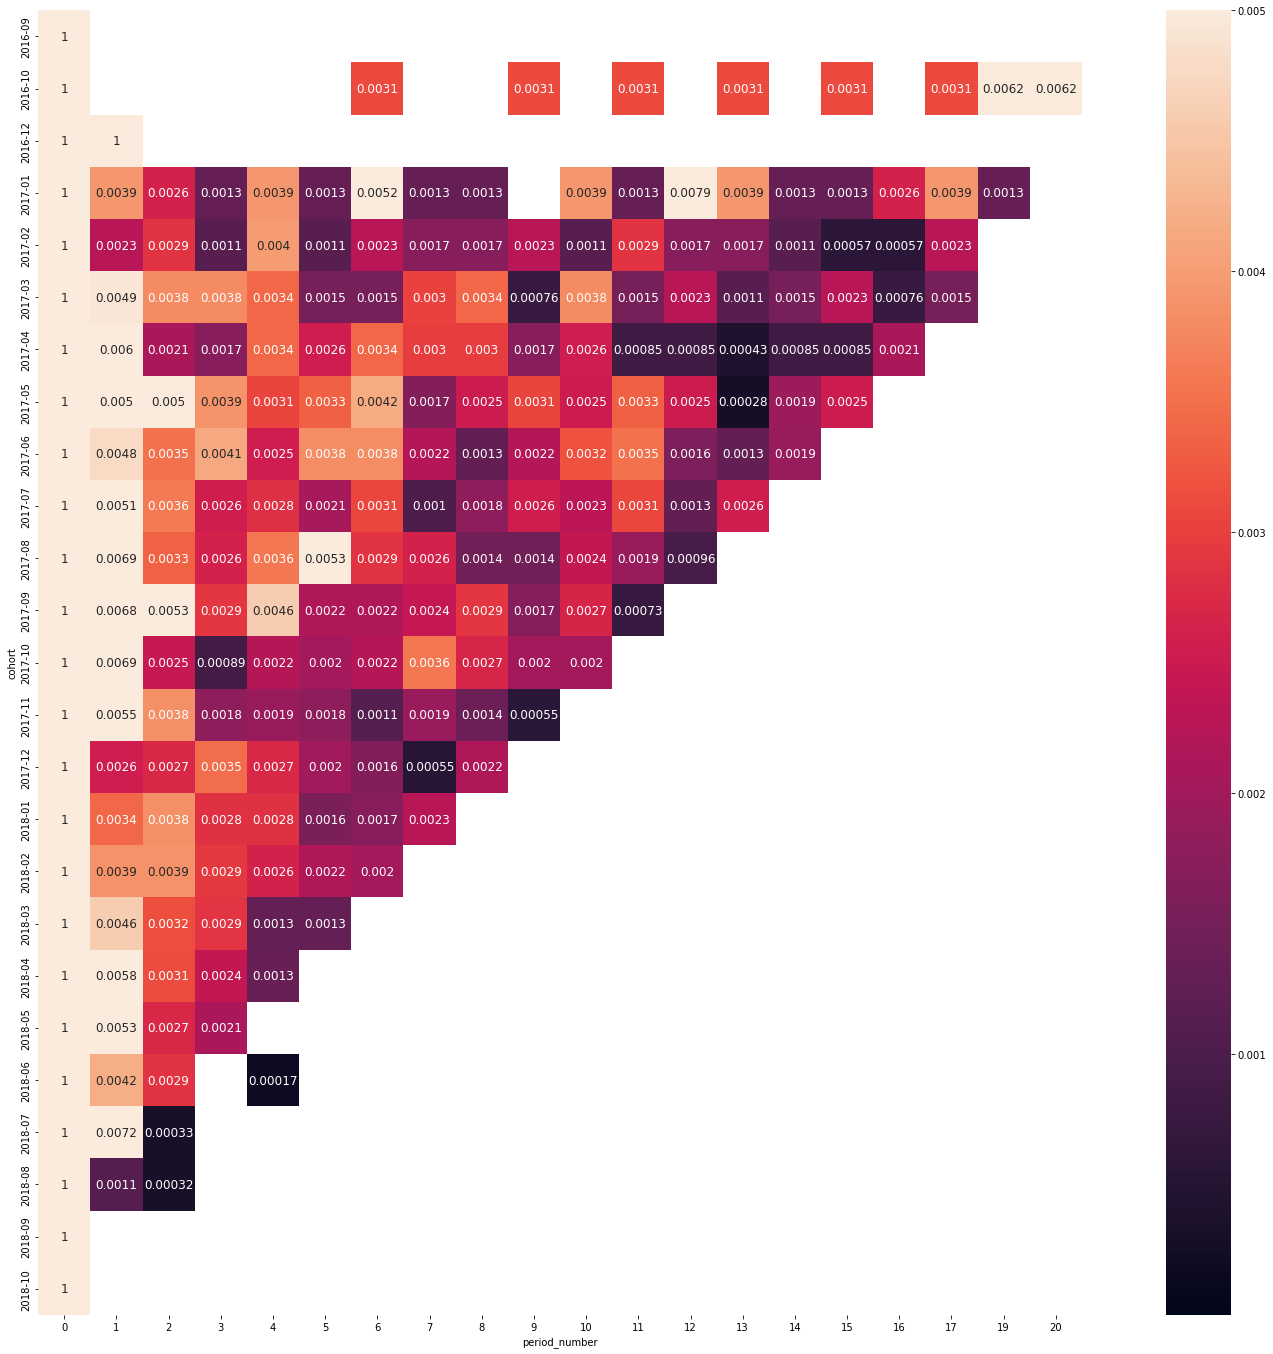

In [115]:
plt.figure(figsize=(30, 24))
sns.heatmap(retention_matrix, annot=True, annot_kws={"size": 12}, square=True, vmin=0.00000002, vmax=0.005)


### Ответ: когорта 2017-06 имеет самый высокий retention (долю вернувшихся пользователей ) за 3й месяц

#### 6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построю RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации выберу следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Для каждого RFM-сегмента построю границы метрик recency, frequency и monetary  для интерпретации этих кластеров.

In [159]:
# соединяем нужные данные в одну таблицу
task_6 = customers_df.merge(orders_df, on='customer_id')

In [160]:
task_6.shape

(99441, 12)

In [177]:
# отбираю только те данные, которые считаю за покупку
task_6 = task_6.query('order_status!="canceled" and order_status!="unavailable"')
task_6

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05


In [162]:
task_6.order_status.value_counts()

order_status
delivered     96478
shipped        1107
invoiced        314
processing      301
created           5
approved          2
Name: count, dtype: int64

In [163]:
# находим последнюю дату покупки для каждого пользователя
df_6 = task_6.groupby('customer_unique_id', as_index=False)\
    .agg({'order_purchase_timestamp':'max'})\
    .rename(columns = {'order_purchase_timestamp':'order_purchase_timestamp_max'})

# создаем столбец с текущей датой
df_6 ['now']=datetime.datetime.now()

In [164]:
df_6.dtypes

customer_unique_id                      object
order_purchase_timestamp_max    datetime64[ns]
now                             datetime64[ns]
dtype: object

In [165]:
# посчитала время от последней покупки до настоящего времени(recency)
df_6['time_diff'] = (df_6['now'] - df_6['order_purchase_timestamp_max']).dt.days
df_6

,customer_unique_id,order_purchase_timestamp_max,now,time_diff
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2023-10-09 12:55:33.047427,1978
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2023-10-09 12:55:33.047427,1981
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2023-10-09 12:55:33.047427,2403
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2023-10-09 12:55:33.047427,2187
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2023-10-09 12:55:33.047427,2154
...,...,...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2023-10-09 12:55:33.047427,2313
94986,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,2023-10-09 12:55:33.047427,2128
94987,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,2023-10-09 12:55:33.047427,2434
94988,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,2023-10-09 12:55:33.047427,1985


In [166]:
# посчитала количество покупок для каждого пользователя (frequency) 
df_quantity = task_6.groupby('customer_unique_id', as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'quantity_orders'})

df_quantity

,customer_unique_id,quantity_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,1
94986,fffea47cd6d3cc0a88bd621562a9d061,1
94987,ffff371b4d645b6ecea244b27531430a,1
94988,ffff5962728ec6157033ef9805bacc48,1


In [167]:
order_items_df.shape

(112650, 7)

In [168]:
df_items_6 = task_6.merge(order_items_df, on='order_id').drop_duplicates()
df_items_6

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112096,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
112097,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
112098,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
112099,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [169]:
df_items_6['revenue'] = df_items_6.order_item_id * df_items_6.price    
# посчитала сумму покупок за все время(monetary)


In [170]:
RFM_table = df_6.merge(df_quantity, on='customer_unique_id',how='inner')\
    .merge(df_items_6, on='customer_unique_id',how='inner' )\
    .rename(columns = {'time_diff':'recency',
                       'quantity_orders':'frequency',
                       'revenue':'monetary'}).drop_duplicates()\
   .set_index('customer_unique_id')

In [171]:
RFM_table= RFM_table[['recency','frequency','monetary']]
RFM_table

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,1978,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1981,1,18.90
0000f46a3911fa3c0805444483337064,2403,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,2187,1,25.99
0004aac84e0df4da2b147fca70cf8255,2154,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2313,1,1360.00
fffea47cd6d3cc0a88bd621562a9d061,2128,1,64.89
ffff371b4d645b6ecea244b27531430a,2434,1,89.90


In [172]:
RFM_table.reset_index().describe()
#???

,recency,frequency,monetary
count,112101.000000,112101.000000,112101.000000
mean,2103.757326,1.082586,136.314384
std,152.585654,0.393654,216.166166
min,1862.000000,1.000000,0.850000
25%,1980.000000,1.000000,45.000000
50%,2084.000000,1.000000,84.000000
75%,2211.000000,1.000000,149.900000
max,2590.000000,16.000000,13440.000000


In [173]:
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary
0.25,1980.0,1.0,45.0
0.50,2084.0,1.0,84.0
0.75,2211.0,1.0,149.9


In [174]:
# Преобразовываем квантили в словарь, более простой в использования
quantiles = quantiles.to_dict()
##  RFM Segmentation ----
RFM_Segment = RFM_table.copy()
# функция для определения границ каждого параметра
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Применяем функцию для определения RFM класса для каждого пользователя    
RFM_Segment['R_Quartile'] = RFM_Segment['recency'].apply(R_Class, args=('recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['frequency'].apply(FM_Class, args=('frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['monetary'].apply(FM_Class, args=('monetary',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str) 

In [175]:
# получили таблицу с RFM сегминтацией
RFM_Segment

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1978,1,129.90,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,1981,1,18.90,3,1,1,311
0000f46a3911fa3c0805444483337064,2403,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,2187,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,2154,1,180.00,2,1,4,214
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2313,1,1360.00,1,1,4,114
fffea47cd6d3cc0a88bd621562a9d061,2128,1,64.89,2,1,2,212
ffff371b4d645b6ecea244b27531430a,2434,1,89.90,1,1,3,113


###  Получили таблицу RFM сегминатции. Пример RFM-сегмента 413 (recency=4, frequency=1, monetary=3) имеет границы метрик recency (время от последней покупки пользователя до текущей даты) от 0 до 1980 дней, frequency (количество покупок за все время) 0 или 1 , monetary (сумма покупок за всё время) от 149,9 до 13440  рублей за все время. 